In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
!unzip '/content/drive/MyDrive/Fraud Detection/Proj3.zip' -d '/content/drive/MyDrive/project_3/'

unzip:  cannot find or open /content/drive/MyDrive/Fraud Detection/Proj3.zip, /content/drive/MyDrive/Fraud Detection/Proj3.zip.zip or /content/drive/MyDrive/Fraud Detection/Proj3.zip.ZIP.


In [4]:
train = pd.read_csv("./drive/MyDrive/Fraud Detection/Proj3/train_transaction.csv")

#remove null columns

In [ ]:
for col in train.columns:
  if train[col].isna().sum() > 50000:
    train.drop(labels=[col], axis=1, inplace=True)

#encode categorical data and drop transaction ID


In [7]:
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

one_hot = []
for i in train.columns:
  if i == 'isFraud':
    continue
  if len(np.unique(train[i].astype(str))) == 1:
    train.drop([i], inplace=True, axis=1)
    continue
  if all(isinstance(x, int) or isinstance(x, float) for x in train[i]):
    if len(np.unique(train[i].astype(str))) <= 3:
      one_hot.append(i)
  else:
    if len(np.unique(train[i].astype(str))) <= 3:
      one_hot.append(i)
    else:
      train.drop([i], inplace=True, axis=1)

X = np.array(train)
for col in one_hot:
  data = train[col].astype(str)
  values = np.array(data)
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  X = np.concatenate((X,onehot_encoded), axis =1)

sparse = []
for i in X:
  sparse.append(i[132:])

train.drop(labels=one_hot, axis=1, inplace=True)
train.drop(['TransactionID'], axis=1, inplace=True)
train = np.concatenate((np.array(train),np.array(sparse)), axis=1)


#separate fraud and normal

In [8]:
normal = []
fraud = []
for i in train:
  if i[0] == 0:
    normal.append(i)
  else:
    fraud.append(i)
normalX = []
for i in normal:
  normalX.append(i[1:])
fraudX = []
for i in fraud:
  fraudX.append(i[1:])


#fill nulls

In [11]:
normalX = pd.DataFrame(normalX).fillna(0)
fraudX = pd.DataFrame(fraudX).fillna(0)

#Scale Data

In [12]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

normalX = sc.fit_transform(normalX)
fraudX = sc.fit_transform(fraudX)

#separate autoencoder training data and test data from normal dataset

In [13]:
trainX = normalX[:120000]
normal_test = normalX[120000:]

In [15]:
pd.DataFrame(trainX)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104
0,0.000000e+00,0.002137,0.743044,0.000000,0.649351,0.599156,0.000213,0.000176,0.0,0.000000,0.000000,0.000444,0.0,0.0000,0.004762,0.000000,0.000627,0.0,0.000343,0.000700,0.021875,0.000000,0.000709,0.000000,0.0,0.000000,0.000000,0.000000,0.000778,0.000000,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.25,0.25,0.2,...,0.0,0.03125,0.014706,0.0,0.000000,0.0,0.000000,0.0,0.0,0.014925,0.000948,0.003096,0.000000,0.000778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,0.0000,0.00000,0.000803,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000873,0.000000,0.0,0.0,0.0
1,6.359409e-08,0.000900,0.100885,0.673333,0.649351,0.430380,0.000213,0.000176,0.0,0.000000,0.000000,0.000444,0.0,0.0000,0.000000,0.000000,0.000314,0.0,0.000343,0.000700,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.25,0.25,0.2,...,0.0,0.03125,0.014706,0.0,0.000000,0.0,0.000000,0.0,0.0,0.014925,0.000948,0.003096,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,0.0000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,4.387992e-06,0.001840,0.210566,0.816667,0.649351,0.700422,0.000213,0.000176,0.0,0.000000,0.000000,0.000444,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.000343,0.000700,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.25,0.25,0.2,...,0.0,0.03125,0.014706,0.0,0.000000,0.0,0.000000,0.0,0.0,0.014925,0.000948,0.003096,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,0.0000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,6.295815e-06,0.001558,0.984824,0.945000,0.649351,0.493671,0.000427,0.000879,0.0,0.000000,0.000000,0.001775,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.008568,0.000700,0.175000,0.001136,0.034043,0.028689,0.0,0.113636,0.142857,0.001151,0.029572,0.025862,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.25,0.25,0.2,...,0.0,0.00000,0.000000,0.0,0.105263,0.0,0.129032,0.0,0.0,0.014925,0.000948,0.003096,0.001151,0.029549,0.025862,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,0.0000,0.00046,0.012061,0.008502,0.0,0.006422,0.0,0.002449,0.0,0.0,0.0,0.000533,0.010476,0.008022,0.0,0.0,0.0
4,6.740974e-06,0.001558,0.201023,0.856667,0.649351,0.430380,0.000213,0.000176,0.0,0.000000,0.000000,0.000444,0.0,0.0003,0.000000,0.000307,0.000314,0.0,0.000343,0.000700,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.25,0.25,0.2,...,0.0,0.03125,0.014706,0.0,0.000000,0.0,0.000000,0.0,0.0,0.014925,0.000948,0.003096,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.05,0.0625,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,1.479663e-01,0.001840,0.125201,0.816667,0.649351,0.953586,0.000213,0.000527,0.0,0.000000,0.000000,0.001775,0.0,0.0000,0.004762,0.000000,0.000627,0.0,0.006169,0.000700,0.784375,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.25,0.25,0.2,...,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.014925,0.000948,0.003096,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,0.0000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
119996,1.479669e-01,0.011628,0.162164,0.185000,0.649351,0.924051,0.000213

#Autoencoder

In [19]:
from keras.models import Sequential , Model
from keras.layers import Dense, Dropout,Input,BatchNormalization , Add

encoder_input = Input(105,name = 'input_encoder')
encoder = Dense(100, activation='relu',name = 'encoder_layer1')(encoder_input)
encoder = Dense(50, activation='relu',name = 'encoder_layer2')(encoder)
encoder = BatchNormalization(name = 'encoder_layer3')(encoder)
encoder = Dropout(0.2 , name = 'encoder_layer4')(encoder)
encoder = Dense(500, activation='relu',name = 'encoder_layer5')(encoder)
encoder = Dense(100, activation='relu',name = 'encoder_layer6')(encoder)
encoder_output = Dense(10, activation='relu',name = 'output_encoder')(encoder)

Encoder = Model(inputs= [encoder_input], outputs=[encoder_output],name = 'Encoder')

decoder_input = Input(10,name = 'input_decoder')
decoder = Dense(100, activation='relu',name = 'decoder_layer1')(decoder_input)
decoder = Dense(200, activation='relu',name = 'decoder_layer2')(decoder)
decoder = BatchNormalization(name = 'decoder_layer3')(decoder)
decoder = Dropout(0.2 , name = 'decoder_layer4')(decoder)
decoder = Dense(50, activation='relu',name = 'decoder_layer5')(decoder)
decoder = Dense(300, activation='relu',name = 'decoder_layer6')(decoder)
decoder = Dropout(0.2 , name = 'decoder_layer10')(decoder)
decoder_output = Dense(105,activation = 'sigmoid',name ='output_layer')(decoder)

Decoder = Model(inputs= [decoder_input], outputs=[decoder_output],name = 'Decoder')

autoencoder_input = Input(105,name = 'input_autoencoder')
latent = Encoder(autoencoder_input)
decoded_data = Decoder(latent)
autoencoder = Model(inputs= [autoencoder_input], outputs=[decoded_data],name = 'AutoEncoder')

print(Encoder.summary())
print(Decoder.summary())
autoencoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   [(None, 105)]             0         
_________________________________________________________________
encoder_layer1 (Dense)       (None, 100)               10600     
_________________________________________________________________
encoder_layer2 (Dense)       (None, 50)                5050      
_________________________________________________________________
encoder_layer3 (BatchNormali (None, 50)                200       
_________________________________________________________________
encoder_layer4 (Dropout)     (None, 50)                0         
_________________________________________________________________
encoder_layer5 (Dense)       (None, 500)               25500     
_________________________________________________________________
encoder_layer6 (Dense)       (None, 100)               5010

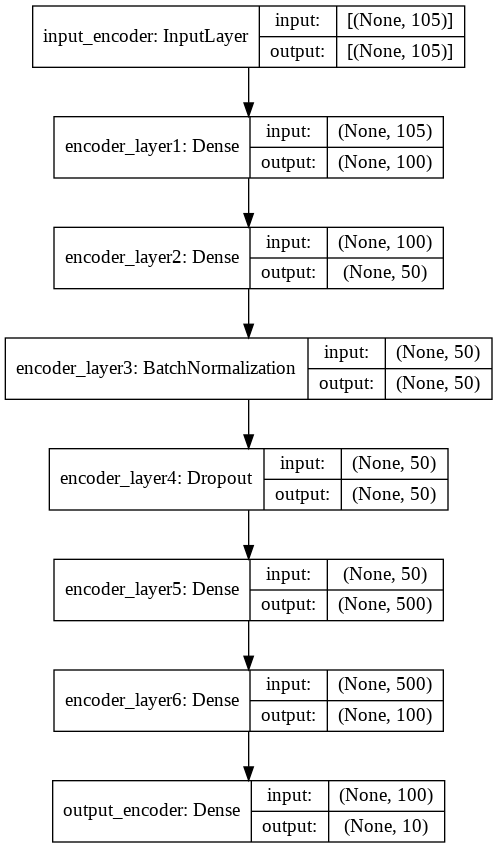

In [23]:
from keras.utils import plot_model

plot_model(Encoder, show_shapes=True)

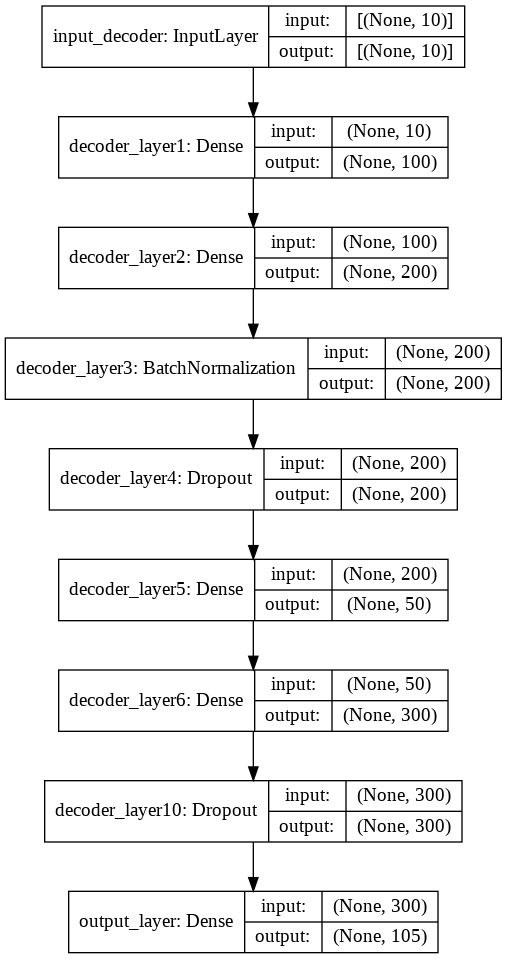

In [24]:
plot_model(Decoder, show_shapes=True)

In [27]:
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(trainX, trainX,
                    batch_size = 128,
                    validation_split = 0.2,
                              epochs= 20)

Epoch 1/20
750/750 [==============================] - 10s 12ms/step - loss: 2.3120e-04 - val_loss: 2.3247e-04
Epoch 2/20
750/750 [==============================] - 8s 11ms/step - loss: 2.1542e-04 - val_loss: 1.8999e-04
Epoch 3/20
750/750 [==============================] - 8s 11ms/step - loss: 2.0634e-04 - val_loss: 2.2317e-04
Epoch 4/20
750/750 [==============================] - 9s 11ms/step - loss: 1.9535e-04 - val_loss: 2.2084e-04
Epoch 5/20
750/750 [==============================] - 9s 11ms/step - loss: 1.8686e-04 - val_loss: 2.4617e-04
Epoch 6/20
750/750 [==============================] - 8s 11ms/step - loss: 1.8524e-04 - val_loss: 2.0320e-04
Epoch 7/20
750/750 [==============================] - 8s 11ms/step - loss: 1.7719e-04 - val_loss: 1.5759e-04
Epoch 8/20
750/750 [==============================] - 9s 11ms/step - loss: 1.6744e-04 - val_loss: 1.5089e-04
Epoch 9/20
750/750 [==============================] - 8s 11ms/step - loss: 1.6325e-04 - val_loss: 1.7507e-04
Epoch 10/20
750/75

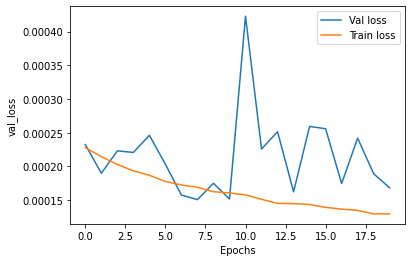

In [38]:
from matplotlib import pyplot as plt

val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss)
plt.plot(
    loss)
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.legend(['Val loss','Train loss'], loc='upper right')
plt.savefig('plot_loss.png')
plt.show()


#find threshold

In [33]:
from keras import losses
import seaborn as sns
import matplotlib.pyplot as plt 

fin_th_normal = normal_test
predicted_x = autoencoder.predict(x=fin_th_normal)
normal_loss = losses.mse(predicted_x, fin_th_normal)
print('normal loss mean', np.mean(normal_loss))

find_th_fraud = fraudX
predicted_fraud_x = autoencoder.predict(x=find_th_fraud)
fraud_loss = losses.mse(predicted_fraud_x, find_th_fraud)
print('fraud loss mean', np.mean(fraud_loss))


normal loss mean 0.003912184008173916
fraud loss mean 0.006646305519309844


threshold = 0.005

#calculate accuracy

In [35]:
predicted_wrong = 0
predicted_right = 0
for i in normal_loss:
  if i < 0.005:
    predicted_right += 1
  else:
    predicted_wrong += 1
for i in fraud_loss:
  if i > 0.005:
    predicted_right += 1
  else:
    predicted_wrong += 1
print(predicted_right, predicted_wrong)

322434 148106


In [36]:
accuracy = predicted_right / (predicted_right + predicted_wrong)
print(accuracy)

0.6852424873549539
